# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import random

# Menetapkan Seed untuk Reproduksibilitas

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Custom Kelas Dataset

In [3]:
class SkinDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformasi Data

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Memuat Dataset

In [5]:
train_csv = "data/train/_classes.csv"
val_csv = "data/valid/_classes.csv"
test_csv = "data/test/_classes.csv"
train_dir = "data/train"
val_dir = "data/valid"
test_dir = "data/test"

In [6]:
train_dataset = SkinDataset(csv_file=train_csv, root_dir=train_dir, transform=transform)
val_dataset = SkinDataset(csv_file=val_csv, root_dir=val_dir, transform=transform)
test_dataset = SkinDataset(csv_file=test_csv, root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inisialisasi Model

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout layer dengan p=0.5 untuk mengurangi overfitting
    nn.Linear(model.fc.in_features, 3)
)
model = model.to(device)

C:\Users\VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Mendeklarasikan Fungsi Loss, Optimizer, dan Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Membuat Method Training dan Validation

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, torch.max(labels, 1)[1])

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Training Data dan Validasi Data

In [11]:
num_epochs = 10
patience = 3
early_stop_counter = 0
best_val_loss = float('inf')

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "./models/model2.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/10
Train Loss: 0.9588, Train Acc: 0.5518
Val Loss: 0.8348, Val Acc: 0.6552
Epoch 2/10
Train Loss: 0.5932, Train Acc: 0.7417
Val Loss: 0.6457, Val Acc: 0.7471
Epoch 3/10
Train Loss: 0.4007, Train Acc: 0.8376
Val Loss: 0.6622, Val Acc: 0.8046
Epoch 4/10
Train Loss: 0.2847, Train Acc: 0.8879
Val Loss: 0.5699, Val Acc: 0.8276
Epoch 5/10
Train Loss: 0.2120, Train Acc: 0.9373
Val Loss: 0.4467, Val Acc: 0.8391
Epoch 6/10
Train Loss: 0.1763, Train Acc: 0.9345
Val Loss: 0.6267, Val Acc: 0.8276
Epoch 7/10
Train Loss: 0.1245, Train Acc: 0.9554
Val Loss: 0.5958, Val Acc: 0.8506
Epoch 8/10
Train Loss: 0.1491, Train Acc: 0.9468
Val Loss: 0.6338, Val Acc: 0.8736
Early stopping triggered!


# Membuat Plot Confusion Matrix

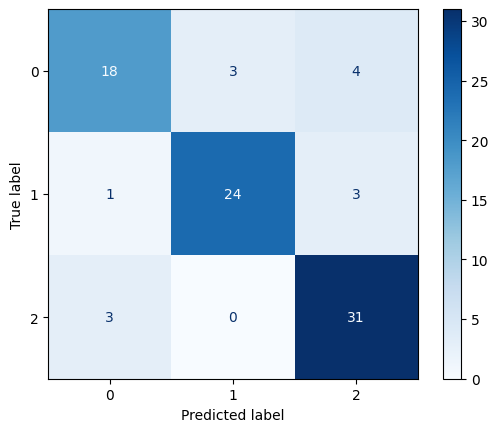

In [ ]:
def plot_confusion_matrix(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

plot_confusion_matrix(val_loader, model, device)


# Membuat Classification Report dan Prediksi

In [ ]:
def get_predictions(loader, model, device):
	model.eval()
	all_preds = []
	all_labels = []

	with torch.no_grad():
		for images, labels in loader:
			images, labels = images.to(device), labels.to(device)
			outputs = model(images)
			_, preds = torch.max(outputs, 1)
			all_preds.extend(preds.cpu().numpy())
			all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())

	return all_labels, all_preds

all_labels, all_preds = get_predictions(val_loader, model, device)

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78        25
           1       0.96      0.93      0.95        28
           2       0.82      0.94      0.88        34

    accuracy                           0.87        87
   macro avg       0.88      0.86      0.87        87
weighted avg       0.88      0.87      0.87        87



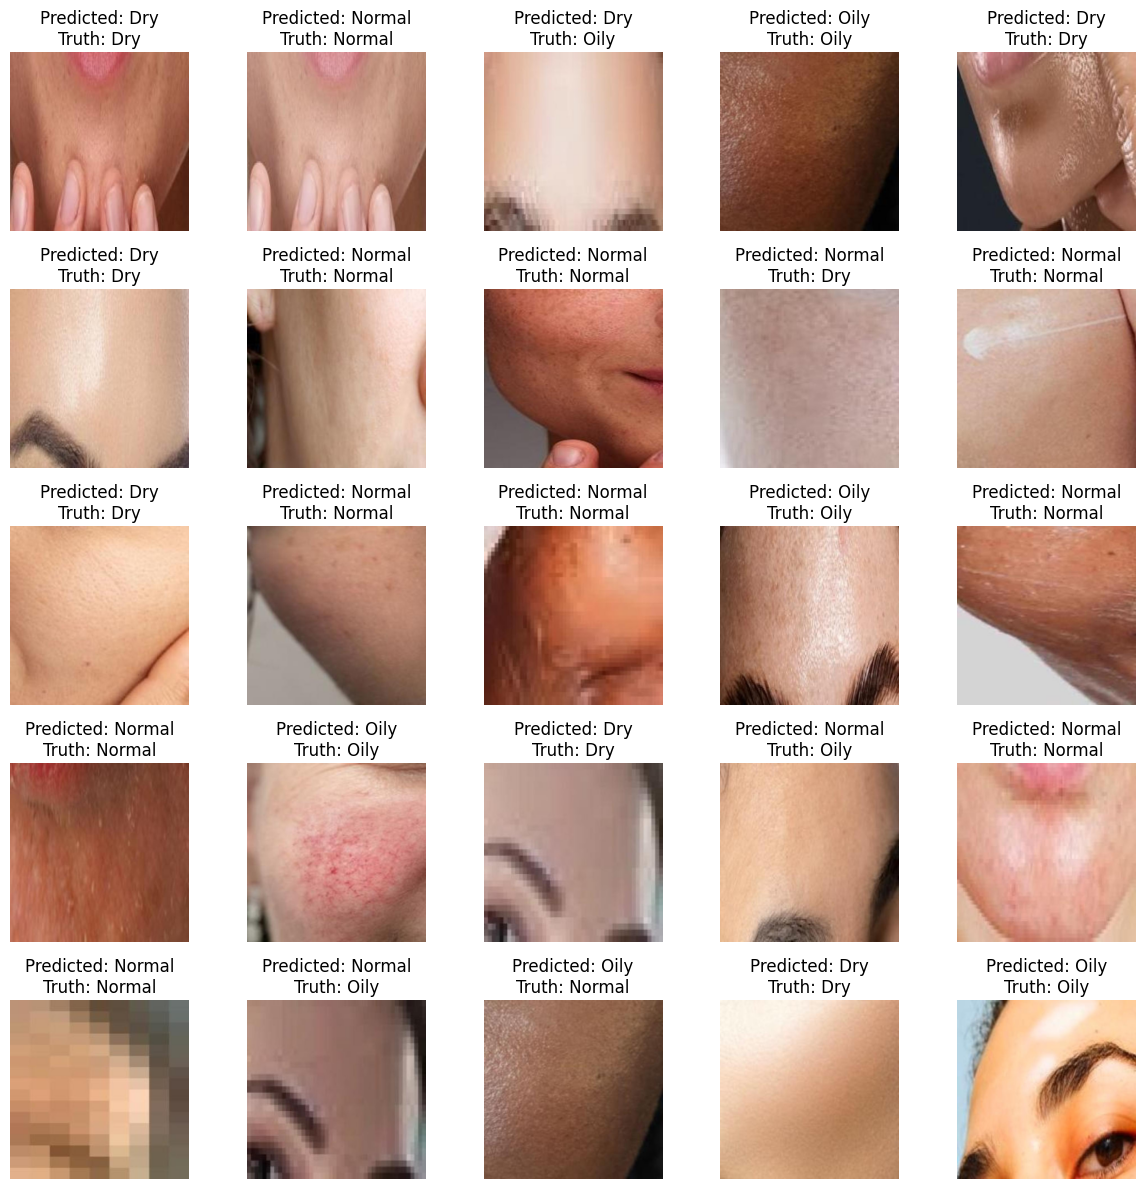

In [ ]:
index_label = {0: 'Oily', 1: 'Dry', 2: 'Normal'}

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
index = 0

axes = axes.flatten()

image_paths = test_dataset.data.iloc[:, 0].values
pred_indices = all_preds
truth_indices = all_labels      

num_images = min(len(image_paths), 25)

for i in range(num_images):
    img_path = os.path.join(test_dir, image_paths[i])
    img = Image.open(img_path).convert("RGB")

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {index_label[pred_indices[i]]}\nTruth: {index_label[truth_indices[i]]}")

plt.tight_layout()
plt.show()


# Plot Loss/Akurasi Training dan Validasi

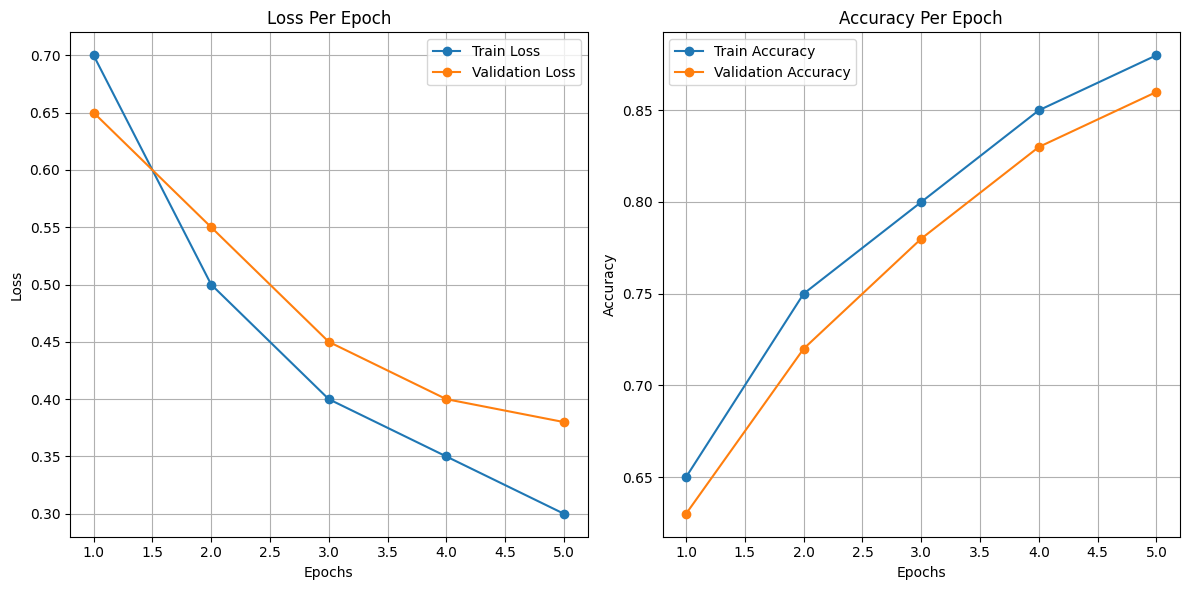

In [16]:

train_losses = [0.7, 0.5, 0.4, 0.35, 0.3]
val_losses = [0.65, 0.55, 0.45, 0.4, 0.38]
train_accuracies = [0.65, 0.75, 0.8, 0.85, 0.88]
val_accuracies = [0.63, 0.72, 0.78, 0.83, 0.86]
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.title("Loss Per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o")
plt.title("Accuracy Per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()